## 1.Prise en main des packages mvtnorm et MixSim

https://www.jstatsoft.org/index.php/jss/article/view/v051i12/v51i12.pdf

### 1.1 Simulation et visualisation d’une gaussienne multivariée

### 1.2 Simulation de jeux donnés à partir de mélanges gaussiens multivariées

In [78]:
library("MixSim")

set.seed(6)

Q1 <- MixSim(MaxOmega = 0.00005, K = 2, p = 2, sph = TRUE, PiLow = 0.5)
Q2 <- MixSim( BarOmega = 0.1, K = 3, p = 2, sph = TRUE, PiLow = 0.5)
Q3 <- MixSim(BarOmega = 0.05, K = 3, p = 2, sph = FALSE, PiLow = 0.7)

A1 <- simdataset(n = 500, Pi = Q1$Pi, Mu = Q1$Mu, S = Q1$S)
A2 <- simdataset(n = 500, Pi = Q2$Pi, Mu = Q2$Mu, S = Q2$S)
A3 <- simdataset(n = 500, Pi = Q3$Pi, Mu = Q3$Mu, S = Q3$S)

write.csv(A1,"dataset1.csv", row.names = FALSE)
write.csv(A2,"dataset2.csv", row.names = FALSE)
write.csv(A3,"dataset3.csv", row.names = FALSE)

In [20]:
# Importation des bibliothèques
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [21]:
# Lire les données
dataset1 = pd.read_csv("dataset1.csv", header=0, index_col=None)
dataset2 = pd.read_csv("dataset2.csv", header=0, index_col=None)
dataset3 = pd.read_csv("dataset3.csv", header=0, index_col=None)

# Rennomer les colonnes de chaque jeux de données
columns = ["x1", "x2", "target"]
dataset1.columns = columns
dataset2.columns = columns
dataset3.columns = columns

# Convertir le type du target de int à category
dataset1.target = dataset1.target.astype("category")
dataset2.target = dataset2.target.astype("category")
dataset3.target = dataset3.target.astype("category")

## 2.Visualisation des Jeux de Données

### Visualisation du premier jeux de données

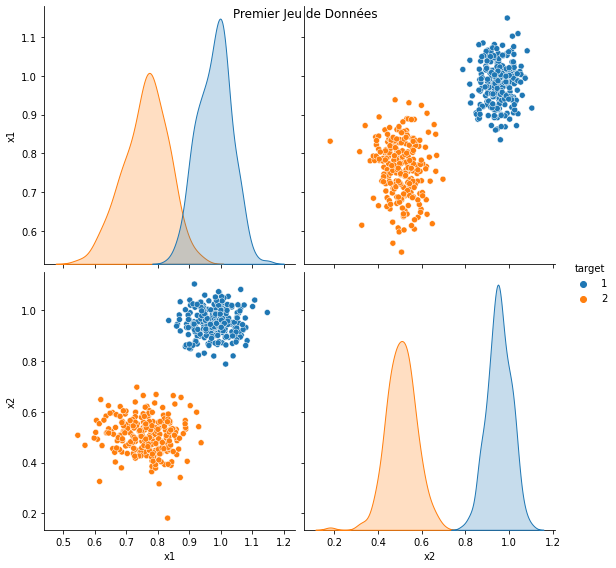

In [22]:
sns.pairplot(dataset1, hue="target", height=4).fig.suptitle("Premier Jeu de Données")
plt.show()

### Visualisation du deuxime jeux de données

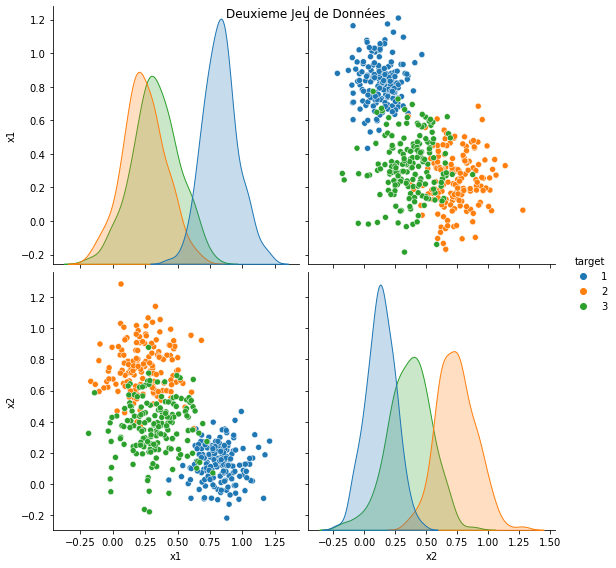

In [23]:
sns.pairplot(dataset2, hue="target", height=4).fig.suptitle("Deuxieme Jeu de Données")
plt.show()

### Visualisation du troisieme jeux de données

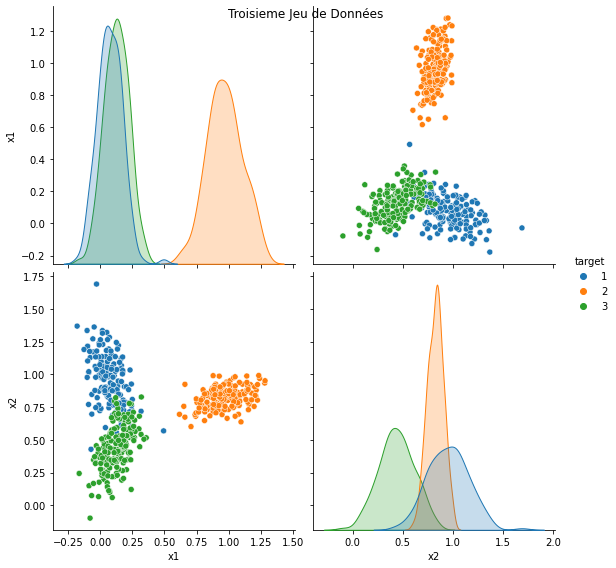

In [24]:
sns.pairplot(dataset3, hue="target", height=4).fig.suptitle("Troisieme Jeu de Données")
plt.show()

## 3.Classifieur linéaire et quadratique

### Split train validation

In [25]:
def split_train_validation(dataset, p_validation):
    
    validation_size = int(p_validation * dataset.shape[0])

    index = np.arange(dataset1.shape[0])
    np.random.shuffle(index)

    validation_x = dataset.iloc[index[:validation_size], :-1].values
    validation_label = dataset.iloc[index[:validation_size], -1].values
    
    train_x = dataset.iloc[index[validation_size:], :-1].values
    train_label = dataset.iloc[index[validation_size:], -1].values

    return (train_x, train_label), (validation_x, validation_label)

In [26]:
(train_x_1, train_label_1), (validation_x_1, validation_label_1) = split_train_validation(dataset1, 0.2)
(train_x_2, train_label_2), (validation_x_2, validation_label_2) = split_train_validation(dataset2, 0.2)
(train_x_3, train_label_3), (validation_x_3, validation_label_3) = split_train_validation(dataset3, 0.2)

### Construction d"un classifieur basé sur l'analyse discrimante quadratique

In [28]:
class AnalyseDiscrimanteQuadratique():
    
    def __init__(self,):
        
        self.estimator = None
        
    
    def fit(self, X, y):
        
        # convertir y en valeur categorielles
        y = y.astype('category')
        
        # estimation des parametres
        self.estimator = {
            'labels': y.categories.values,
            'mu_wi':  [X[y == category].mean(axis=0) for category in y.categories],
            'cov_matrix_wi': [np.cov(np.transpose(X[y == category])) for category in y.categories],
            'prob_priori_wi':  [(y == category).sum()/len(y) for category in y.categories]
        }
        
    
    def __g_wi(self, X, mu, cov_matrix, prob_priori): 
        
        # Calculer la matrice inversée
        cov_matrix_inv = np.linalg.inv(cov_matrix)
        return (np.log(prob_priori) - 1/2 * np.log(np.linalg.det(cov_matrix)) - 1/2 * (X - mu).T @ cov_matrix_inv @ (X - mu)).flatten()[0]
        
        
    def predict(self, X):
        
        if self.estimator is None:
            raise NotImplementedError()

        pred = []
        
        for i in range(X.shape[0]):
            g_wi = [self.__g_wi(X[i], self.estimator["mu_wi"][j], self.estimator["cov_matrix_wi"][j], self.estimator["prob_priori_wi"][j] ) for j in range(self.estimator["labels"].shape[0])]
            pred.append(self.estimator["labels"][np.argmax(g_wi)])
            
        return np.array(pred)

### Evaluation

In [183]:
def evaluation(pred, labels):
    # Classification report
    print(classification_report(labels, pred))
    # Calculate the confusion matrix
    cm = confusion_matrix(labels, pred)
    sns.heatmap(cm,  annot=True, fmt='d')
    plt.show()

In [189]:
def plot_frontiere(dataset, classifier, step=300):
   
    X = dataset.iloc[:, :-1].values
    Y = dataset.iloc[:, -1].values.astype("category")
    
    mmax=X.max(axis=0)
    mmin=X.min(axis=0)
    
    x1grid,x2grid=np.meshgrid(np.linspace(mmin[0],mmax[0],step),np.linspace(mmin[1],mmax[1],step))
    
    grid=np.hstack((x1grid.reshape(x1grid.size,1),x2grid.reshape(x2grid.size,1)))
    
    res = np.array([classifier.predict(grid[i].reshape(1, -1))[0] for i in range(grid.shape[0])])

    colors_points = ["orange", "blue", "green"]
    colors_font = ["wheat", "cyan", "lime"]
    
    plt.figure(figsize=(8, 8))

    for i in range(Y.categories.shape[0]):

        plt.scatter(grid[:, 0][res == Y.categories[i]], grid[:, 1][res ==  Y.categories[i]], c=colors_font[i])
        plt.scatter(X[:, 0][Y == Y.categories[i]], X[:, 1][Y ==  Y.categories[i]], c=colors_points[i], label="classe "+str(Y.categories[i]))

    plt.legend()
    plt.show()

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        58
           2       1.00      1.00      1.00        42

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



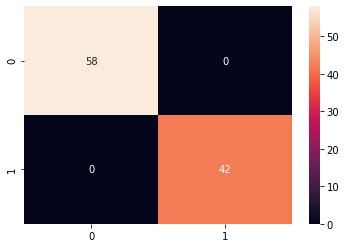

In [190]:
adq1 = AnalyseDiscrimanteQuadratique()

adq1.fit(train_x_1, train_label_1)

pred_1 = adq1.predict(validation_x_1)

evaluation(pred_1, validation_label_1)

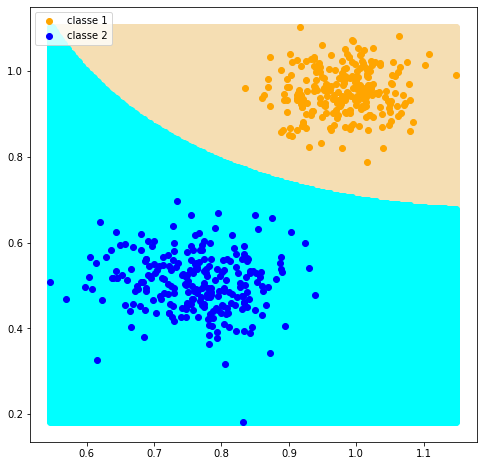

In [191]:
plot_frontiere(dataset1, adq1)

              precision    recall  f1-score   support

           1       0.97      0.97      0.97        29
           2       0.88      0.90      0.89        39
           3       0.84      0.81      0.83        32

    accuracy                           0.89       100
   macro avg       0.89      0.89      0.89       100
weighted avg       0.89      0.89      0.89       100



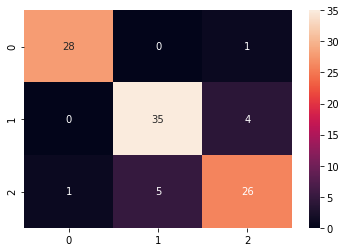

In [192]:
adq2 = AnalyseDiscrimanteQuadratique()

adq2.fit(train_x_2, train_label_2)

pred_2 = adq2.predict(validation_x_2)

evaluation(pred_2, validation_label_2)

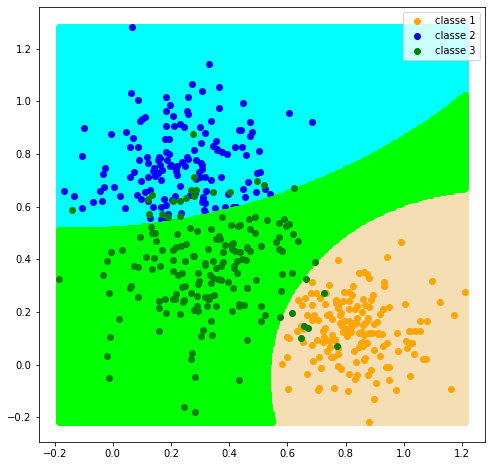

In [193]:
plot_frontiere(dataset2, adq2)

              precision    recall  f1-score   support

           1       0.94      0.91      0.92        33
           2       1.00      1.00      1.00        40
           3       0.89      0.93      0.91        27

    accuracy                           0.95       100
   macro avg       0.94      0.95      0.94       100
weighted avg       0.95      0.95      0.95       100



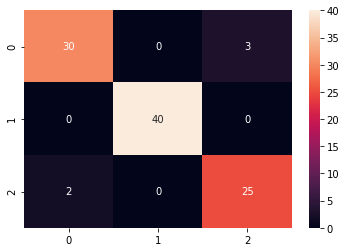

In [194]:
adq3 = AnalyseDiscrimanteQuadratique()

adq3.fit(train_x_3, train_label_3)

pred_3 = adq3.predict(validation_x_3)

evaluation(pred_3, validation_label_3)

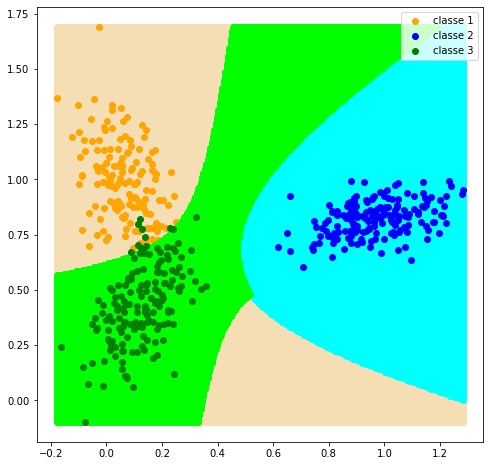

In [195]:
plot_frontiere(dataset3, adq3)